In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import time
import datetime

%matplotlib inline

#These two lines will tell jupyter notebook to print all vars instead of last listed var
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
class XML2DataFrame:

    def __init__(self, xml_data):
        self.root = ET.XML(xml_data)

    def parse_root(self, root):
        return [self.parse_element(child) for child in iter(root)]

    def parse_element(self, element, parsed=None):
        if parsed is None:
            parsed = dict()
        for key in element.keys():
            parsed[key] = element.attrib.get(key)
        if element.text:
            parsed[element.tag] = element.text
        for child in list(element):
            self.parse_element(child, parsed)
        return parsed

    def process_data(self):
        structure_data = self.parse_root(self.root)
        return pd.DataFrame(structure_data)

In [ ]:
# Get list of XML file names from the data directory
import os 

files = []
directory = os.fsencode("data")
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".xml"): 
        #print(filename)
        files.append("data\\" + filename)
        continue
    else:
        continue
                     
files

In [ ]:
# Create an empty dataframe for us to add all our data into
master_df = pd.DataFrame()
master_df

In [ ]:
# Create an empty list for us to track column names for each year's worth of data
column_names = []

In [ ]:
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
print('start time = ', st)

# For every xml file in the directory, convert xml file to dataframe
# Add the dataframe to the master dataframe
for f in files:
    xml_data = open(f).read()
    xml2df = XML2DataFrame(xml_data)
    xml_dataframe = xml2df.process_data()
    column_names.append(xml_dataframe.columns)
    master_df = pd.concat([master_df,xml_dataframe], ignore_index=True)
    open(f).close()
    
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
print('end time = ', st)

In [ ]:
# Check the master dataframe
master_df.info()

In [ ]:
# Write the master dataframe to CSV
master_df.to_csv('TFS_OPEN_DATA-2011-2016.csv', encoding='utf-8', index=False)

In [ ]:
# Column names for each of the data files 
column_names

In [ ]:
# Find the differences in column names between the data
# Print the columns which were found in one data set but not another
for i in range(1, len(column_names)):
    print ("i = " + str(i))
    print (set(column_names[i]) - set(column_names[i-1]))
    print (set(column_names[i-1]) - set(column_names[i]))

In [ ]:
# Let's shorten the dataframe name so we can write code easier and peek at the data
df = master_df
df.head(10)

In [2]:
df = pd.read_csv('TFS_OPEN_DATA-2011-2016.csv')
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (43,50,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,AGE_OF_STRUCTURE,AID_TO_FROM_OTHER_DEPTS,ALARM_TO_FD,AREA_OF_ORIGIN,ARRIVE_DATE,ARRIVE_TIME,BLD_HEIGHT,...,SMOKE_ALARM_PRESENCE_AND_OPERATION_MAIN_FLOOR,SMOKE_ALARM_TYPE,SPRINKLER_SYSTEM_ACTIVATION,SPRINKLER_SYSTEM_PRESENCE,STATUS_ON_ARRIVAL,TOTAL_NUM_PERSONNEL,TSSA,VEH_FUEL,VEH_PURPOSE,WATER
0,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:10:02,2011-01-01 00:10:02,0,...,NaN,NaN,NaN,NaN,NaN,4,,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:09:02,2011-01-01 00:09:02,0,...,NaN,NaN,NaN,NaN,NaN,4,,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:09:34,2011-01-01 00:09:34,0,...,NaN,NaN,NaN,NaN,NaN,4,,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:10:46,2011-01-01 00:10:46,0,...,NaN,NaN,NaN,NaN,NaN,4,,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1,5.0,NaN,2011-01-01 00:11:03,2011-01-01 00:12:38,0,...,NaN,NaN,NaN,NaN,NaN,14,,NaN,NaN,NaN


In [3]:
# Note that there are 107 columns, but not all of them can be shown on screen
# So let's peek at the first few rows, 10 columns at a time to look at a sample of the data
for i in range(0, len(df.columns), 10):
    df.iloc[:,i:i+10].head()

,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,AGE_OF_STRUCTURE,AID_TO_FROM_OTHER_DEPTS,ALARM_TO_FD,AREA_OF_ORIGIN,ARRIVE_DATE,ARRIVE_TIME,BLD_HEIGHT
0,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:10:02,2011-01-01 00:10:02,0
1,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:09:02,2011-01-01 00:09:02,0
2,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:09:34,2011-01-01 00:09:34,0
3,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:10:46,2011-01-01 00:10:46,0
4,NaN,NaN,NaN,NaN,1,5.0,NaN,2011-01-01 00:11:03,2011-01-01 00:12:38,0


,BLD_STATUS,CAD_UNIT_ID,CANUTEC,CIVILIAN_FIRE_FATALITY,CIVILIAN_FIRE_INJURY,CIV_EVACUATION,CIV_EVACUATION_REASON_1,CIV_EVACUATION_REASON_2,CIV_FIRE_CONTROL,CLEAR_TIME
0,NaN,P342,,0,0,NaN,NaN,NaN,NaN,2011-01-01 00:31:19
1,NaN,A131,,0,0,NaN,NaN,NaN,NaN,2011-01-01 00:15:14
2,NaN,A324,,0,0,NaN,NaN,NaN,NaN,2011-01-01 00:27:12
3,NaN,R345,,0,0,NaN,NaN,NaN,NaN,2011-01-01 00:20:40
4,NaN,R411,,0,0,NaN,NaN,NaN,NaN,2011-01-01 00:15:31


,COMPLEX,CONTROL_DATE,CONTROL_HOUR,CONTROL_MIN,CONTROL_SEC,CROSS_STREET,DISPATCH_DATE,DISPATCH_HOUR,DISPATCH_MIN,DISPATCH_SEC
0,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01 00:04:13,0.0,4.0,13.0
1,NaN,NaN,NaN,NaN,NaN,LAWRENCE AVE E,2011-01-01 00:04:46,0.0,4.0,46.0
2,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01 00:05:50,0.0,5.0,50.0
3,NaN,NaN,NaN,NaN,NaN,SYLVAN AVE,2011-01-01 00:06:33,0.0,6.0,33.0
4,NaN,NaN,NaN,NaN,NaN,SAN VAROWAY,2011-01-01 00:06:41,0.0,6.0,41.0


,DISPATCH_TIME,EMS,ENROUTE_TIME,ESA,EST_KM,EST_LOSS,EST_NUM_PERSONS_DISPLACED,EST_VALUE_AT_RISK,EVENT_ALARM_LEVEL,EVENT_TYPE
0,2011-01-01 00:04:13,,2011-01-01 00:05:45,,1,0,0,NaN,NaN,Medical
1,2011-01-01 00:04:46,,2011-01-01 00:07:30,,1,0,0,NaN,NaN,Carbon Monoxide - Non Medical
2,2011-01-01 00:05:50,,NaN,,1,0,0,NaN,NaN,Medical
3,2011-01-01 00:06:33,,2011-01-01 00:08:48,,2,0,0,NaN,NaN,Fire - Grass/Rubbish
4,2011-01-01 00:06:41,,2011-01-01 00:09:07,,1,0,0,NaN,NaN,Alarm Highrise Residential


,EVENT_TYPE_CD,EXTENT_FIRE,EXTENT_SMOKE,FD_STATION,FF_FATALITIES,FF_INJURIES,FIRE_ALARM_SYSTEM_IMPACT,FIRE_ALARM_SYSTEM_OPERATION,FIRE_ALARM_SYSTEM_PRESENCE,FIRE_CONTROL
0,MEB,NaN,NaN,F11000010000,0,0,NaN,NaN,NaN,NaN
1,CONM,NaN,NaN,F11000011000,0,0,NaN,NaN,NaN,NaN
2,MEPI,NaN,NaN,F11000012000,0,0,NaN,NaN,NaN,NaN
3,FIG,NaN,NaN,F11000013000,0,0,NaN,NaN,NaN,NaN
4,FAHR,NaN,NaN,F11000014000,0,0,NaN,NaN,NaN,NaN


,FIRE_DEPT_INCIDENT,FSA,FUEL_OF_IGNITION_SOURCE,GAS,HYDRO,IGNITION_SOURCE,INCIDENT_DATE,INCIDENT_NUMBER,INITIAL_CALL_HOUR,INITIAL_CALL_MIN
0,NaN,M6N,NaN,,,NaN,01/01/2011,F11000010,0,3
1,NaN,NaN,NaN,,,NaN,01/01/2011,F11000011,0,3
2,NaN,M4M,NaN,,,NaN,01/01/2011,F11000012,0,5
3,NaN,NaN,NaN,,,NaN,01/01/2011,F11000013,0,4
4,NaN,NaN,NaN,,,NaN,01/01/2011,F11000014,0,6


,INITIAL_CALL_SEC,INITIAL_DETECTION,INITIAL_UNIT_PERSONNEL,INSURANCE_ESTIMATE,LEVEL_OF_ORIGIN,MAIN_STREET,MOE,MOL,MUNICIPAL_BUILDING_OFFICE,MUNICIPAL_HEALTH_OFFICE
0,43,NaN,4,NaN,NaN,NaN,,,,
1,55,NaN,4,NaN,NaN,MOUNT PLEASANT RD,,,,
2,3,NaN,4,NaN,NaN,NaN,,,,
3,46,NaN,4,NaN,NaN,DUFFERIN ST,,,,
4,7,NaN,4,NaN,NaN,SAN ROMANOWAY,,,,


,MUNICIPAL_POLICE,OBJECT_OR_MATERIAL_FIRST_IGNITED,OCC_STATUS,OCC_TYPE,OFM_INVESTIGATIONS_CONTACTED,ONSCENE_HOUR,ONSCENE_MIN,ONSCENE_SEC,OPP,OTHER
0,,NaN,NaN,NaN,0,0.0,10.0,2.0,,
1,,NaN,NaN,NaN,0,0.0,9.0,2.0,,
2,,NaN,NaN,NaN,0,0.0,9.0,34.0,,
3,,NaN,NaN,NaN,0,0.0,10.0,46.0,,
4,,NaN,NaN,NaN,0,0.0,11.0,3.0,,


,PHYSICAL_CONDITION_1,PHYSICAL_CONDITION_2,PHYSICAL_CONDITION_3,POSSIBLE_BUSINESS_IMPACT,POSSIBLE_CAUSE,PROPERTY,RESCUED_ADULTS,RESCUED_CHILDREN,RESCUED_SENIORS,RESCUES
0,NaN,NaN,NaN,NaN,NaN,301,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,301,0,0,0,0
2,NaN,NaN,NaN,NaN,NaN,302,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,861,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,323,0,0,0,0


,RESPONDING_UNITS,RESPONSE_TYPE,SMOKE_ALARM_FAILURE_TO_OPERATE,SMOKE_ALARM_IMPACT_ON_EVAC,SMOKE_ALARM_IMPACT_ON_NUM_EVAC,SMOKE_ALARM_ON_ALL_FLOORS,SMOKE_ALARM_OTHER_FLOOR_PRESENCE,SMOKE_ALARM_PRESENCE_AND_OPERATION_MAIN_FLOOR,SMOKE_ALARM_TYPE,SPRINKLER_SYSTEM_ACTIVATION
0,1.0,89,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1.0,38,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1.0,89,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1.0,3,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4,4.0,33,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


,SPRINKLER_SYSTEM_PRESENCE,STATUS_ON_ARRIVAL,TOTAL_NUM_PERSONNEL,TSSA,VEH_FUEL,VEH_PURPOSE,WATER
0,NaN,NaN,4,,NaN,NaN,NaN
1,NaN,NaN,4,,NaN,NaN,NaN
2,NaN,NaN,4,,NaN,NaN,NaN
3,NaN,NaN,4,,NaN,NaN,NaN
4,NaN,NaN,14,,NaN,NaN,NaN


In [4]:
# Describe the data 10 columns at a time
for i in range(0, len(df.columns), 10):
    df.iloc[:,i:i+10].describe(include='all')

,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,AGE_OF_STRUCTURE,AID_TO_FROM_OTHER_DEPTS,ALARM_TO_FD,AREA_OF_ORIGIN,ARRIVE_DATE,ARRIVE_TIME,BLD_HEIGHT
count,12330.000000,12330.000000,12330.000000,8781.000000,720370.000000,720369.000000,12330.000000,703568,703286,720370.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,702206,701934,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-18 14:46:23,2014-02-18 14:50:51,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,NaN
mean,13.016221,29.183698,15.863909,4.486619,3.948327,3.018321,52.261800,NaN,NaN,0.745987
std,6.731811,17.383903,19.192811,2.236060,0.390321,1.396097,26.564199,NaN,NaN,25.721413
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,11.000000,NaN,NaN,0.000000
25%,8.000000,14.000000,0.000000,3.000000,4.000000,3.000000,24.000000,NaN,NaN,0.000000
50%,14.000000,29.500000,4.000000,4.000000,4.000000,3.000000,50.000000,NaN,NaN,0.000000
75%,19.000000,44.750000,30.000000,5.000000,4.000000,3.000000,79.000000,NaN,NaN,0.000000


,BLD_STATUS,CAD_UNIT_ID,CANUTEC,CIVILIAN_FIRE_FATALITY,CIVILIAN_FIRE_INJURY,CIV_EVACUATION,CIV_EVACUATION_REASON_1,CIV_EVACUATION_REASON_2,CIV_FIRE_CONTROL,CLEAR_TIME
count,8781.000000,719347,720370,720370.000000,720370.000000,12329.000000,12329.000000,105.000000,12329.000000,719310
unique,NaN,245,2,NaN,NaN,NaN,NaN,NaN,NaN,718157
top,NaN,HR332,,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-23 17:59:21
freq,NaN,20713,720138,NaN,NaN,NaN,NaN,NaN,NaN,4
mean,1.564173,NaN,NaN,0.000085,0.001224,2.608565,7.143888,6.038095,2.984833,NaN
std,1.791434,NaN,NaN,0.010862,0.049103,1.670131,2.422162,3.240144,2.048570,NaN
min,1.000000,NaN,NaN,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,NaN
25%,1.000000,NaN,NaN,0.000000,0.000000,1.000000,8.000000,3.000000,1.000000,NaN
50%,1.000000,NaN,NaN,0.000000,0.000000,3.000000,8.000000,8.000000,3.000000,NaN
75%,1.000000,NaN,NaN,0.000000,0.000000,4.000000,8.000000,9.000000,4.000000,NaN


,COMPLEX,CONTROL_DATE,CONTROL_HOUR,CONTROL_MIN,CONTROL_SEC,CROSS_STREET,DISPATCH_DATE,DISPATCH_HOUR,DISPATCH_MIN,DISPATCH_SEC
count,8781.000000,241537,12549.000000,12549.000000,12549.000000,330021,719679,720193.000000,720193.000000,720193.000000
unique,NaN,2181,NaN,NaN,NaN,11025,718149,NaN,NaN,NaN
top,NaN,01/01/00,NaN,NaN,NaN,YONGE ST,2015-05-27 02:07:02,NaN,NaN,NaN
freq,NaN,228988,NaN,NaN,NaN,6409,4,NaN,NaN,NaN
mean,50.761189,NaN,13.017133,28.967886,18.825245,NaN,NaN,12.953839,29.499231,29.501899
std,45.892300,NaN,6.729716,17.468068,19.579309,NaN,NaN,6.364254,17.308797,17.315648
min,1.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000
25%,3.000000,NaN,8.000000,14.000000,0.000000,NaN,NaN,9.000000,15.000000,15.000000
50%,20.000000,NaN,14.000000,30.000000,13.000000,NaN,NaN,13.000000,30.000000,29.000000
75%,98.000000,NaN,19.000000,45.000000,35.000000,NaN,NaN,18.000000,44.000000,45.000000


,DISPATCH_TIME,EMS,ENROUTE_TIME,ESA,EST_KM,EST_LOSS,EST_NUM_PERSONS_DISPLACED,EST_VALUE_AT_RISK,EVENT_ALARM_LEVEL,EVENT_TYPE
count,719347,720370,694192,720370,720370.000000,7.203700e+05,720370.000000,12412.000000,117426.000000,720290
unique,717829,2,692851,2,NaN,NaN,NaN,NaN,NaN,114
top,2014-03-28 13:04:15,,2013-11-27 15:28:59,,NaN,NaN,NaN,NaN,NaN,Medical
freq,4,720325,4,720080,NaN,NaN,NaN,NaN,NaN,354742
mean,NaN,NaN,NaN,NaN,2.536828,4.651726e+02,0.216719,12.765227,0.006157,NaN
std,NaN,NaN,NaN,NaN,2.096576,2.377162e+04,13.344641,29.129809,0.101701,NaN
min,NaN,NaN,NaN,NaN,-1.000000,0.000000e+00,0.000000,1.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,2.000000,0.000000e+00,0.000000,2.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,2.000000,0.000000e+00,0.000000,2.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,3.000000,0.000000e+00,0.000000,5.000000,0.000000,NaN


,EVENT_TYPE_CD,EXTENT_FIRE,EXTENT_SMOKE,FD_STATION,FF_FATALITIES,FF_INJURIES,FIRE_ALARM_SYSTEM_IMPACT,FIRE_ALARM_SYSTEM_OPERATION,FIRE_ALARM_SYSTEM_PRESENCE,FIRE_CONTROL
count,720338,8785.000000,8785.000000,720370.0,720370.0,720370.000000,8781.000000,8781.000000,8781.000000,12330.000000
unique,130,NaN,NaN,375479.0,NaN,NaN,NaN,NaN,NaN,NaN
top,Medical,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
freq,158831,NaN,NaN,343538.0,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.944223,9.503813,NaN,0.0,0.000373,5.702312,4.543788,3.256007,1.674371
std,NaN,8.677514,21.090830,NaN,0.0,0.024287,3.047831,3.540627,3.264821,1.105352
min,NaN,1.000000,2.000000,NaN,0.0,0.000000,1.000000,1.000000,1.000000,1.000000
25%,NaN,1.000000,2.000000,NaN,0.0,0.000000,2.000000,1.000000,1.000000,1.000000
50%,NaN,2.000000,4.000000,NaN,0.0,0.000000,7.000000,2.000000,1.000000,1.000000
75%,NaN,2.000000,7.000000,NaN,0.0,0.000000,8.000000,8.000000,8.000000,3.000000


,FIRE_DEPT_INCIDENT,FSA,FUEL_OF_IGNITION_SOURCE,GAS,HYDRO,IGNITION_SOURCE,INCIDENT_DATE,INCIDENT_NUMBER,INITIAL_CALL_HOUR,INITIAL_CALL_MIN
count,344884,365309,12330.000000,720370,720370,12330.000000,720370,720338,720370.000000,720370.000000
unique,344866,119,NaN,2,2,NaN,2192,720311,NaN,NaN
top,F14016411000,M5A,NaN,,,NaN,22/12/2013,F14087165,NaN,NaN
freq,4,10398,NaN,715150,715966,NaN,2752,4,NaN,NaN
mean,NaN,NaN,50.843471,NaN,NaN,344.025223,NaN,NaN,12.953513,29.486386
std,NaN,NaN,46.222753,NaN,NaN,438.305932,NaN,NaN,6.360580,17.309359
min,NaN,NaN,1.000000,NaN,NaN,11.000000,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,4.000000,NaN,NaN,30.000000,NaN,NaN,9.000000,14.000000
50%,NaN,NaN,13.000000,NaN,NaN,77.000000,NaN,NaN,13.000000,29.000000
75%,NaN,NaN,99.000000,NaN,NaN,999.000000,NaN,NaN,18.000000,44.000000


,INITIAL_CALL_SEC,INITIAL_DETECTION,INITIAL_UNIT_PERSONNEL,INSURANCE_ESTIMATE,LEVEL_OF_ORIGIN,MAIN_STREET,MOE,MOL,MUNICIPAL_BUILDING_OFFICE,MUNICIPAL_HEALTH_OFFICE
count,720370.000000,8786.000000,720370.000000,12412.000000,8781,354910,720370,720370,720370,720370
unique,NaN,NaN,NaN,NaN,57,10633,2,2,2,2
top,NaN,NaN,NaN,NaN,001,,,,,
freq,NaN,NaN,NaN,NaN,3437,55096,719011,720080,720142,719008
mean,29.486100,4.704075,3.823512,5.517241,NaN,NaN,NaN,NaN,NaN,NaN
std,17.330296,2.197287,0.726919,3.354577,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,14.000000,2.000000,4.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,30.000000,6.000000,4.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,45.000000,6.000000,4.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN


,MUNICIPAL_POLICE,OBJECT_OR_MATERIAL_FIRST_IGNITED,OCC_STATUS,OCC_TYPE,OFM_INVESTIGATIONS_CONTACTED,ONSCENE_HOUR,ONSCENE_MIN,ONSCENE_SEC,OPP,OTHER
count,720370,12330.000000,8781.000000,8781.000000,720370.000000,704999.000000,704999.000000,704999.000000,720370,720370
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,
freq,718973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,719431,717388
mean,NaN,57.287105,1.939870,2.590366,0.001588,12.968655,29.531011,29.451555,NaN,NaN
std,NaN,26.580936,2.261751,2.324710,0.039819,6.369351,17.311981,17.340799,NaN,NaN
min,NaN,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,43.000000,1.000000,1.000000,0.000000,9.000000,15.000000,14.000000,NaN,NaN
50%,NaN,48.000000,1.000000,2.000000,0.000000,14.000000,30.000000,29.000000,NaN,NaN
75%,NaN,74.000000,1.000000,2.000000,0.000000,18.000000,45.000000,44.000000,NaN,NaN


,PHYSICAL_CONDITION_1,PHYSICAL_CONDITION_2,PHYSICAL_CONDITION_3,POSSIBLE_BUSINESS_IMPACT,POSSIBLE_CAUSE,PROPERTY,RESCUED_ADULTS,RESCUED_CHILDREN,RESCUED_SENIORS,RESCUES
count,12329.000000,47.000000,7.000000,8785.000000,12330.000000,710507.0,720370.000000,720370.000000,720370.000000,720370.000000
unique,NaN,NaN,NaN,NaN,NaN,627.0,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,323.0,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,196014.0,NaN,NaN,NaN,NaN
mean,56.899586,59.404255,57.142857,4.736255,53.545904,NaN,0.000923,0.000136,0.000204,0.026538
std,47.906928,47.645274,52.206093,3.489868,30.187137,NaN,0.077282,0.017316,0.022198,0.371500
min,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.500000,1.000000,44.000000,NaN,0.000000,0.000000,0.000000,0.000000
50%,98.000000,98.000000,99.000000,8.000000,50.000000,NaN,0.000000,0.000000,0.000000,0.000000
75%,98.000000,98.000000,99.000000,8.000000,60.000000,NaN,0.000000,0.000000,0.000000,0.000000


,RESPONDING_UNITS,RESPONSE_TYPE,SMOKE_ALARM_FAILURE_TO_OPERATE,SMOKE_ALARM_IMPACT_ON_EVAC,SMOKE_ALARM_IMPACT_ON_NUM_EVAC,SMOKE_ALARM_ON_ALL_FLOORS,SMOKE_ALARM_OTHER_FLOOR_PRESENCE,SMOKE_ALARM_PRESENCE_AND_OPERATION_MAIN_FLOOR,SMOKE_ALARM_TYPE,SPRINKLER_SYSTEM_ACTIVATION
count,720338.000000,720370.00000,8781.000000,8781.000000,720370.000000,8781.000000,8781.000000,8781.000000,8781.000000,8781.000000
mean,2.283411,67.17408,73.839540,5.013210,0.230744,4.349049,4.791254,2.931329,4.757545,6.254299
std,2.234218,39.80317,40.839988,3.194751,4.459870,3.633355,2.997842,2.421703,3.161500,2.825953
min,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,34.00000,9.000000,1.000000,0.000000,1.000000,2.000000,2.000000,2.000000,3.000000
50%,1.000000,89.00000,98.000000,7.000000,0.000000,2.000000,3.000000,2.000000,4.000000,8.000000
75%,4.000000,89.00000,98.000000,8.000000,0.000000,9.000000,8.000000,3.000000,8.000000,8.000000
max,453.000000,922.00000,99.000000,9.000000,99.000000,9.000000,9.000000,9.000000,9.000000,9.000000


,SPRINKLER_SYSTEM_PRESENCE,STATUS_ON_ARRIVAL,TOTAL_NUM_PERSONNEL,TSSA,VEH_FUEL,VEH_PURPOSE,WATER
count,8781.000000,12330.000000,720370.000000,720370,1739.000000,1739.000000,12330.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,,NaN,NaN,NaN
freq,NaN,NaN,NaN,719822,NaN,NaN,NaN
mean,3.576814,3.008516,8.043410,NaN,4.073606,4.246694,2.472912
std,2.505426,1.975314,7.099159,NaN,16.263838,13.442653,2.388659
min,1.000000,1.000000,0.000000,NaN,1.000000,1.000000,1.000000
25%,2.000000,1.000000,4.000000,NaN,1.000000,1.000000,1.000000
50%,3.000000,3.000000,4.000000,NaN,1.000000,1.000000,1.000000
75%,3.000000,4.000000,13.000000,NaN,1.000000,1.000000,5.000000


## Data Wrangling

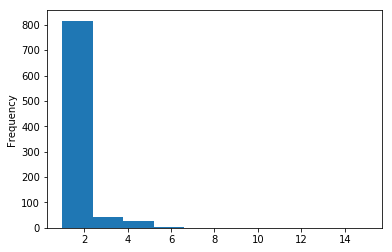

In [5]:
# Combine all injuries and fatalities into a total number of injuries attribute
df['Injuries'] = (df.filter(regex='INJUR|FATAL').astype(int)).sum(axis=1)

# Let's see what the spread of injuries look like
df[df['Injuries']>0].Injuries.sort_values().plot(kind='hist')

In [6]:
# Since there isn't great variety in the number of injuries, let's refine
# this attribute to 0 for no injury, 1 for (any number of) injuries exist
df['Injuries'] = (df['Injuries'] > 0).astype(int)
df['Injuries'].groupby(df['Injuries']).count()

Injuries
0    719479
1       891
Name: Injuries, dtype: int64

In [7]:
# Remove the attribues we no longer need
df = df.drop(df.filter(regex='INJUR|FATAL').columns, axis=1)

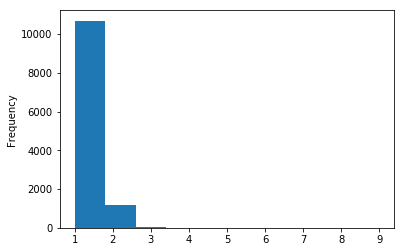

In [8]:
# Combine number of the other agencies contacted to a single attribute
other_agencies = ['OPP','MOE','TSSA','ESA','MOL','EMS','CANUTEC','GAS','HYDRO']

# We'll start by converting the blank spaces to numeric values
for agency in other_agencies:
    df[agency] = pd.to_numeric(df[agency], errors='coerce').fillna(0)
df['Agencies_contacted'] = df[other_agencies].astype(int).sum(axis=1)

# Let's see what the data spread looks like
df[df['Agencies_contacted']>0].Agencies_contacted.sort_values().plot(kind='hist')

In [9]:
# Since there isn't great variety in the number other agencies contacted, let's refine
# this attribute to 0 for no other agency contacted, 1 for (any number of) other agency contacted
df['Agencies_contacted'] = (df['Agencies_contacted'] > 0).astype(int)
df['Agencies_contacted'].groupby(df['Agencies_contacted']).count()

Agencies_contacted
0    708434
1     11936
Name: Agencies_contacted, dtype: int64

In [10]:
# Remove the attribues we no longer need
df = df.drop(df[other_agencies], axis=1)

In [11]:
# Let's look at the data that has date and time info
df.filter(regex='DATE|HOUR|MIN|SEC').head()

,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,ARRIVE_DATE,CONTROL_DATE,CONTROL_HOUR,CONTROL_MIN,CONTROL_SEC,DISPATCH_DATE,DISPATCH_HOUR,DISPATCH_MIN,DISPATCH_SEC,INCIDENT_DATE,INITIAL_CALL_HOUR,INITIAL_CALL_MIN,INITIAL_CALL_SEC,ONSCENE_HOUR,ONSCENE_MIN,ONSCENE_SEC
0,NaN,NaN,NaN,2011-01-01 00:10:02,NaN,NaN,NaN,NaN,2011-01-01 00:04:13,0.0,4.0,13.0,01/01/2011,0,3,43,0.0,10.0,2.0
1,NaN,NaN,NaN,2011-01-01 00:09:02,NaN,NaN,NaN,NaN,2011-01-01 00:04:46,0.0,4.0,46.0,01/01/2011,0,3,55,0.0,9.0,2.0
2,NaN,NaN,NaN,2011-01-01 00:09:34,NaN,NaN,NaN,NaN,2011-01-01 00:05:50,0.0,5.0,50.0,01/01/2011,0,5,3,0.0,9.0,34.0
3,NaN,NaN,NaN,2011-01-01 00:10:46,NaN,NaN,NaN,NaN,2011-01-01 00:06:33,0.0,6.0,33.0,01/01/2011,0,4,46,0.0,10.0,46.0
4,NaN,NaN,NaN,2011-01-01 00:11:03,NaN,NaN,NaN,NaN,2011-01-01 00:06:41,0.0,6.0,41.0,01/01/2011,0,6,7,0.0,11.0,3.0


In [12]:
# We can see that 'dispatch' information has lots of repeated data
# Let's see if we can optimize by filling in missing data and removing duplicate data
# Let's see again what that data looks like
df.filter(regex='DISPATCH|INCIDENT_DATE').describe(include='all')
df.filter(regex='DISPATCH|INCIDENT_DATE').head()

,DISPATCH_DATE,DISPATCH_HOUR,DISPATCH_MIN,DISPATCH_SEC,DISPATCH_TIME,INCIDENT_DATE
count,719679,720193.000000,720193.000000,720193.000000,719347,720370
unique,718149,NaN,NaN,NaN,717829,2192
top,2015-05-27 02:07:02,NaN,NaN,NaN,2014-03-28 13:04:15,22/12/2013
freq,4,NaN,NaN,NaN,4,2752
mean,NaN,12.953839,29.499231,29.501899,NaN,NaN
std,NaN,6.364254,17.308797,17.315648,NaN,NaN
min,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,9.000000,15.000000,15.000000,NaN,NaN
50%,NaN,13.000000,30.000000,29.000000,NaN,NaN
75%,NaN,18.000000,44.000000,45.000000,NaN,NaN


,DISPATCH_DATE,DISPATCH_HOUR,DISPATCH_MIN,DISPATCH_SEC,DISPATCH_TIME,INCIDENT_DATE
0,2011-01-01 00:04:13,0.0,4.0,13.0,2011-01-01 00:04:13,01/01/2011
1,2011-01-01 00:04:46,0.0,4.0,46.0,2011-01-01 00:04:46,01/01/2011
2,2011-01-01 00:05:50,0.0,5.0,50.0,2011-01-01 00:05:50,01/01/2011
3,2011-01-01 00:06:33,0.0,6.0,33.0,2011-01-01 00:06:33,01/01/2011
4,2011-01-01 00:06:41,0.0,6.0,41.0,2011-01-01 00:06:41,01/01/2011


In [13]:
# We'll try and fill in DISPATCH_DATE it is most complete (within the row) with date and time info 
# First we'll convert the INCIDENT_DATE and DISPATCH_DATE to datetime type so we can work with it easier
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format='%d/%m/%Y')
df['DISPATCH_DATE'] = pd.to_datetime(df['DISPATCH_DATE'], format='%Y-%m-%d %H:%M:%S')

# Next, we'll get indices for rows where DISPATCH_DATE is missing data but data exists for the time attributes
dispatchix = df[df.DISPATCH_DATE.isnull() & df.DISPATCH_HOUR.notnull() & df.DISPATCH_MIN.notnull() & df.DISPATCH_SEC.notnull()].index

# We'll fill in missing time values with 0 so we can convert the attribute to an int
df['DISPATCH_HOUR'] = df['DISPATCH_HOUR'].fillna(0)
df['DISPATCH_MIN'] = df['DISPATCH_MIN'].fillna(0)
df['DISPATCH_SEC'] = df['DISPATCH_SEC'].fillna(0)
df['DISPATCH_HOUR'] = df['DISPATCH_HOUR'].astype(int)
df['DISPATCH_MIN'] = df['DISPATCH_MIN'].astype(int)
df['DISPATCH_SEC'] = df['DISPATCH_SEC'].astype(int)

# Create a temp attribute to contain our combined dispatch date and time information 
df['DISPATCH_TEMP'] = df['INCIDENT_DATE'] + pd.to_timedelta(df.DISPATCH_SEC, unit='s') + pd.to_timedelta(df.DISPATCH_MIN, unit='m') + pd.to_timedelta(df.DISPATCH_HOUR, unit='h')

# Replace our missing data with the data that we've constructed
for ix in dispatchix:
    df.loc[ix,'DISPATCH_DATE'] = df.loc[ix,'DISPATCH_TEMP']

# Confirm that we have fewer missing values now
df.DISPATCH_DATE.describe()

count                  720367
unique                 718832
top       2013-08-03 16:25:57
freq                        4
first     2011-01-01 00:02:50
last      2016-12-31 23:59:58
Name: DISPATCH_DATE, dtype: object

In [14]:
# We'll shorten the column name and drop the others that we no longer need
df.rename({'DISPATCH_DATE': 'DISPATCH'}, axis='columns')
df = df.drop(df.filter(regex='DISPATCH_').columns, axis=1)

,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,AGE_OF_STRUCTURE,AID_TO_FROM_OTHER_DEPTS,ALARM_TO_FD,AREA_OF_ORIGIN,ARRIVE_DATE,ARRIVE_TIME,BLD_HEIGHT,...,SPRINKLER_SYSTEM_ACTIVATION,SPRINKLER_SYSTEM_PRESENCE,STATUS_ON_ARRIVAL,TOTAL_NUM_PERSONNEL,VEH_FUEL,VEH_PURPOSE,WATER,Injuries,Agencies_contacted,DISPATCH_TEMP
0,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:10:02,2011-01-01 00:10:02,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:04:13
1,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:09:02,2011-01-01 00:09:02,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:04:46
2,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:09:34,2011-01-01 00:09:34,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:05:50
3,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:10:46,2011-01-01 00:10:46,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:06:33
4,NaN,NaN,NaN,NaN,1,5.0,NaN,2011-01-01 00:11:03,2011-01-01 00:12:38,0,...,NaN,NaN,NaN,14,NaN,NaN,NaN,0,0,2011-01-01 00:06:41
5,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:13:46,2011-01-01 00:13:46,0,...,NaN,NaN,NaN,17,NaN,NaN,NaN,0,0,2011-01-01 00:07:23
6,0.0,15.0,59.0,NaN,4,1.0,74.0,2011-01-01 00:12:54,2011-01-01 04:30:22,0,...,NaN,NaN,5.0,58,NaN,NaN,1.0,0,0,2011-01-01 00:07:28
7,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:12:43,2011-01-01 00:12:43,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:08:51
8,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:15:44,2011-01-01 00:15:44,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:09:31
9,NaN,NaN,NaN,NaN,4,4.0,NaN,2011-01-01 00:14:28,2011-01-01 00:15:49,0,...,NaN,NaN,NaN,17,NaN,NaN,NaN,0,0,2011-01-01 00:10:10


In [15]:
# We'll do similarly as above for ARRIVE_DATE and ONSCENE_HOUR/MIN/SEC
df['ARRIVE_DATE'] = pd.to_datetime(df['ARRIVE_DATE'], format='%Y-%m-%d %H:%M:%S')
arriveix = df[df.ARRIVE_DATE.isnull() & df.ONSCENE_HOUR.notnull() & df.ONSCENE_MIN.notnull() & df.ONSCENE_SEC.notnull()].index
df['ONSCENE_HOUR'] = df['ONSCENE_HOUR'].fillna(0)
df['ONSCENE_MIN'] = df['ONSCENE_MIN'].fillna(0)
df['ONSCENE_SEC'] = df['ONSCENE_SEC'].fillna(0)
df['ONSCENE_HOUR'] = df['ONSCENE_HOUR'].astype(int)
df['ONSCENE_MIN'] = df['ONSCENE_MIN'].astype(int)
df['ONSCENE_SEC'] = df['ONSCENE_SEC'].astype(int)
df['ARRIVE_TEMP'] = df['INCIDENT_DATE'] + pd.to_timedelta(df.ONSCENE_SEC, unit='s') + pd.to_timedelta(df.ONSCENE_MIN, unit='m') + pd.to_timedelta(df.ONSCENE_HOUR, unit='h')
for ix in dispatchix:
    df.loc[ix,'ARRIVE_DATE'] = df.loc[ix,'ARRIVE_TEMP']
df.rename({'ARRIVE_DATE': 'ONSCENE'}, axis='columns')
df = df.drop(df.filter(regex='ONSCENE_|ARRIVE_DATE').columns, axis=1)

,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,AGE_OF_STRUCTURE,AID_TO_FROM_OTHER_DEPTS,ALARM_TO_FD,AREA_OF_ORIGIN,ONSCENE,ARRIVE_TIME,BLD_HEIGHT,...,SPRINKLER_SYSTEM_ACTIVATION,SPRINKLER_SYSTEM_PRESENCE,STATUS_ON_ARRIVAL,TOTAL_NUM_PERSONNEL,VEH_FUEL,VEH_PURPOSE,WATER,Injuries,Agencies_contacted,ARRIVE_TEMP
0,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:10:02,2011-01-01 00:10:02,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:10:02
1,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:09:02,2011-01-01 00:09:02,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:09:02
2,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:09:34,2011-01-01 00:09:34,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:09:34
3,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:10:46,2011-01-01 00:10:46,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:10:46
4,NaN,NaN,NaN,NaN,1,5.0,NaN,2011-01-01 00:11:03,2011-01-01 00:12:38,0,...,NaN,NaN,NaN,14,NaN,NaN,NaN,0,0,2011-01-01 00:11:03
5,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:13:46,2011-01-01 00:13:46,0,...,NaN,NaN,NaN,17,NaN,NaN,NaN,0,0,2011-01-01 00:13:46
6,0.0,15.0,59.0,NaN,4,1.0,74.0,2011-01-01 00:12:54,2011-01-01 04:30:22,0,...,NaN,NaN,5.0,58,NaN,NaN,1.0,0,0,2011-01-01 00:12:54
7,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:12:43,2011-01-01 00:12:43,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:12:43
8,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:15:44,2011-01-01 00:15:44,0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,0,0,2011-01-01 00:15:44
9,NaN,NaN,NaN,NaN,4,4.0,NaN,2011-01-01 00:14:28,2011-01-01 00:15:49,0,...,NaN,NaN,NaN,17,NaN,NaN,NaN,0,0,2011-01-01 00:14:28


In [16]:
df.filter(regex='DATE|HOUR|MIN|SEC').head()

,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,CONTROL_DATE,CONTROL_HOUR,CONTROL_MIN,CONTROL_SEC,INCIDENT_DATE,INITIAL_CALL_HOUR,INITIAL_CALL_MIN,INITIAL_CALL_SEC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01,0,3,43
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01,0,3,55
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01,0,5,3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01,0,4,46
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01,0,6,7


In [17]:
# TO DO: Combine other time fields into one datetime field

In [18]:
# There are also a number of columns with "RESCUE" in the name
df.filter(regex='RESCUE').head()

,RESCUED_ADULTS,RESCUED_CHILDREN,RESCUED_SENIORS,RESCUES
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [20]:
# We'll combine the RESCUED_* attributes to form a sum
df['RESCUE_SUM'] = (df['RESCUED_ADULTS'] + df['RESCUED_CHILDREN'] + df['RESCUED_SENIORS'])

# And compare the sum with the RESCUES column to see if they're the same data
df[df.RESCUES>0].shape
df[(df.RESCUE_SUM == df.RESCUES) & df.RESCUES>0].shape

(7907, 89)

(209, 89)

In [21]:
# Looks like we have very few crossovers
# In other words, RESUCES != RESCUED_ADULTS + RESCUED_CHILDREN + RESCUED_SENIORS
# So let's combine all 4 attributes to 1 attribute: 0 for no rescues; 1 otherwise 
df['RESCUED'] = ((df['RESCUE_SUM'] > 0) | (df['RESCUES'] > 0)).astype(int)
df['RESCUED'].groupby(df['RESCUED']).count()

RESCUED
0    712322
1      8048
Name: RESCUED, dtype: int64

In [22]:
# We'll drop the columns that we no longer need
df = df.drop(df.filter(regex='RESCUED_|RESCUES').columns, axis=1)